# OpenEO endpoint in Examind - Example - Python Client

By Quentin BIALOTA (Geomatys)

Contact : quentin.bialota@geomatys.com

---

### **/!\ WARNING**
This initial implementation of openEO may contain bugs. Please let me know if you find any.

In this tutorial we will use the python client to create and execute openEO processes on Examind.

---

**Prerequisites :**
- Have an examind (via docker) running on your machine
- Have imported sentinel-2 data in Examind (through the web ui http://localhost/8080/examind [login: admin / password: admin])
- In examind, have created a WCS (in Web Services page) named `test` (with the sentinel-2 data you imported)
- In examind, have created a WPS (in Web Services page) named `test` (you need to enable Versions `1.0.0` **AND** `2.0.0`)
- In the docker compose, have added the following environment variables to the examind service :
  ```yml
    environment:
      EXAMIND_ENABLE_BASIC_AUTH: "true" # To be able to authenticate on openEO endpoints
      EXAMIND_ENABLE_PARAM_TOKEN: "true" # To be able to authenticate on openEO endpoints
      EXAMIND_WPS_EXECUTE_SECURE: "true" # To enable the safety check when executing WPS processes via openEO
  ```

In [55]:
import openeo as eo
import rasterio

SERVER_URL = "http://localhost:8080/examind/WS/openeo/test"
LOGIN = "admin"
PASSWORD = "admin"

### 1 - Connection to the server

In [90]:
connection = eo.connect(SERVER_URL)

print("Authenticate with Basic authentication")
connection.authenticate_basic(LOGIN, PASSWORD)

print(connection)

Authenticate with Basic authentication
<Connection to 'http://localhost:8080/examind/WS/openeo/test/' with BasicBearerAuth>


In [91]:
connection.describe_collection("sentinel_evi_bands")

{'links': [{'href': 'http://localhost:8080/examind/WS/coverage/test/collections/sentinel_evi_bands/coverage',
   'rel': 'items',
   'type': 'image/tiff',
   'hreflang': None,
   'title': 'sentinel_evi_bands',
   'length': None},
  {'href': 'http://localhost:8080/examind/WS/coverage/test/collections/sentinel_evi_bands/coverage?f=image/tiff',
   'rel': 'items',
   'type': 'image/tiff',
   'hreflang': None,
   'title': 'sentinel_evi_bands',
   'length': None},
  {'href': 'http://localhost:8080/examind/WS/coverage/test/collections/sentinel_evi_bands/coverage?f=application/x-netcdf',
   'rel': 'items',
   'type': 'application/x-netcdf',
   'hreflang': None,
   'title': 'sentinel_evi_bands',
   'length': None}],
 'id': 'sentinel_evi_bands',
 'name': 'sentinel_evi_bands',
 'title': 'sentinel_evi_bands',
 'extent': {'srs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84',
  'crs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84',
  'spatial': {'bbox': [[3.8534545898437504,
     43.5408336643793,
     4.577865600585938,
     43.862257524417934]]}},
 'crs': ['http://www.opengis.net/def/crs/OGC/1.3/CRS84'],
 'storageCrs': 'http://www.opengis.net/def/crs/OGC/1.3/CRS84',
 'stac_version': '1.0.0',
 'stac_extensions': [],
 'type': 'Collection',
 'keywords': [],
 'cube:dimensions': {'x': {'type': 'spatial',
   'axis': 'x',
   'extent': [3.8534545898437504, 4.577865600585938],
   'values': None,
   'step': '5.795288085937504E-4',
   'unit': 'degree',
   'reference_system': '84'},
  'y': {'type': 'spatial',
   'axis': 'y',
   'extent': [43.5408336643793, 43.862257524417934],
   'values': None,
   'step': '4.190663103502415E-4',
   'unit': 'degree',
   'reference_system': '84'},
  'bands': {'type': 'bands', 'values': ['0', '1', '2', '3', '4', '5']}},
 'deprecated': False,
 'license': 'no licence specified',
 'summaries': {'bands': [{'unit': 'no unit',
    'name': '0',
    'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '1', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '2', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '3', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '4', 'description': 'Grayscale'},
   {'unit': 'no unit', 'name': '5', 'description': 'Grayscale'}]}}

## Create a process
### Method 1 - Step by step process creation

For this first method we will use directly the functions exposed by the python client

In [99]:
datacube = connection.load_collection(
    "sentinel_evi_bands",
    spatial_extent={"west": 3.87, "south": 43.56, "east": 4.5, "north": 43.85},
    bands=[0,2,4]
)
datacube

In [100]:
# datacube.save_result(format="GTIFF")

datacube.process("save_result", coverage=datacube, format="GTIFF")

In [101]:
datacube.download()

Preflight process graph validation raised: [InvalidArgument] Info : For the process : save_result, no argument named coverage found


OpenEoApiError: [400] InvalidArgument: Info : For the process : save_result, no argument named coverage found --- The process specified is not valid, check the elements of the process graphs.Arguments are maybe incorrect, check ids of the processes,... (ref: db47a8f9-cec1-4f1e-aa3d-36e3a24770cd)

In [88]:
# Band selection
red   = datacube.band(0)
blue  = datacube.band(1)
nir   = datacube.band(2)

# Multiply bands with factors
red_x6 = red.process("geotoolkit.coverage:math:multiplyWithValue", coverage=red, value=6.0)
blue_x7_5 = datacube.process("geotoolkit.coverage:math:multiplyWithValue", coverage=blue, value=7.5)

# Subtract NIR - RED
nir_minus_red = datacube.process("geotoolkit.coverage:math:substract", first=nir, second=red)

# Add NIR + (6*RED)
nir_plus_red_x6 = datacube.process("geotoolkit.coverage:math:sum", first=nir, second=red_x6)

# Add [NIR + 6*RED] + [7.5*BLUE]
nir_plus_red_x6_plus_blue_x7_5 = datacube.process(
    "geotoolkit.coverage:math:sum",
    first=nir_plus_red_x6,
    second=blue_x7_5
)

# Add [NIR + 6*RED + 7.5*BLUE] + 1
denominator = datacube.process(
    "geotoolkit.coverage:math:sumWithValue",
    coverage=nir_plus_red_x6_plus_blue_x7_5,
    value=1.0
)

# Divide numerator / denominator
evi_raw = datacube.process(
    "geotoolkit.coverage:math:divide",
    first=nir_minus_red,
    second=denominator
)

# Multiply result by 2.5
evi = datacube.process(
    "geotoolkit.coverage:math:multiplyWithValue",
    coverage=evi_raw,
    value=2.5
)

red_x6.save_result("GTIFF")

# save = datacube.save_result("GTIFF")

# # Save result in GTIFF
# save = datacube.save_result(format="GTIFF")


Failed to parse API error response: [500] '<!doctype html><html lang="en"><head><title>HTTP Status 500 – Internal Server Error</title><style type="text/css">body {font-family:Tahoma,Arial,sans-serif;} h1, h2, h3, b {color:white;background-color:#525D76;} h1 {font-size:22px;} h2 {font-size:16px;} h3 {font-size:14px;} p {font-size:12px;} a {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 500 – Internal Server Error</h1><hr class="line" /><p><b>Type</b> Exception Report</p><p><b>Message</b> Illegal base64 character 20</p><p><b>Description</b> The server encountered an unexpected condition that prevented it from fulfilling the request.</p><p><b>Exception</b></p><pre>java.lang.IllegalArgumentException: Illegal base64 character 20\n\tjava.base&#47;java.util.Base64$Decoder.decode0(Unknown Source)\n\tjava.base&#47;java.util.Base64$Decoder.decode(Unknown Source)\n\torg.constellation.services.security.CstlUserDetailsExtractor.getUserName

OpenEoApiPlainError: [500] <!doctype html><html lang="en"><head><title>HTTP Status 500 – Internal Server Error</title><style type="text/css">body {font-family:Tahoma,Arial,sans-serif;} h1, h2, h3, b {color:white;background-color:#525D76;} h1 {font-size:22px;} h2 {font-size:16px;} h3 {font-size:14px;} p {font-size:12px;} a {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 500 – Internal Server Error</h1><hr class="line" /><p><b>Type</b> Exception Report</p><p><b>Message</b> Illegal base64 character 20</p><p><b>Description</b> The server encountered an unexpected condition that prevented it from fulfilling the request.</p><p><b>Exception</b></p><pre>java.lang.IllegalArgumentException: Illegal base64 character 20
	java.base&#47;java.util.Base64$Decoder.decode0(Unknown Source)
	java.base&#47;java.util.Base64$Decoder.decode(Unknown Source)
	org.constellation.services.security.CstlUserDetailsExtractor.getUserNameFromBasicAuth(CstlUserDetailsExtractor.java:87)
	org.constellation.services.security.CstlUserDetailsExtractor.userDetails(CstlUserDetailsExtractor.java:54)
	org.constellation.engine.security.AuthenticationTokenProcessingFilter.doFilter(AuthenticationTokenProcessingFilter.java:80)
	org.springframework.security.web.FilterChainProxy$VirtualFilterChain.doFilter(FilterChainProxy.java:374)
	org.springframework.security.web.header.HeaderWriterFilter.doHeadersAfter(HeaderWriterFilter.java:90)
	org.springframework.security.web.header.HeaderWriterFilter.doFilterInternal(HeaderWriterFilter.java:75)
	org.springframework.web.filter.OncePerRequestFilter.doFilter(OncePerRequestFilter.java:116)
	org.springframework.security.web.FilterChainProxy$VirtualFilterChain.doFilter(FilterChainProxy.java:374)
	org.springframework.security.web.context.request.async.WebAsyncManagerIntegrationFilter.doFilterInternal(WebAsyncManagerIntegrationFilter.java:62)
	org.springframework.web.filter.OncePerRequestFilter.doFilter(OncePerRequestFilter.java:116)
	org.springframework.security.web.FilterChainProxy$VirtualFilterChain.doFilter(FilterChainProxy.java:374)
	org.springframework.security.web.context.SecurityContextHolderFilter.doFilter(SecurityContextHolderFilter.java:82)
	org.springframework.security.web.context.SecurityContextHolderFilter.doFilter(SecurityContextHolderFilter.java:69)
	org.springframework.security.web.FilterChainProxy$VirtualFilterChain.doFilter(FilterChainProxy.java:374)
	org.springframework.security.web.session.DisableEncodeUrlFilter.doFilterInternal(DisableEncodeUrlFilter.java:42)
	org.springframework.web.filter.OncePerRequestFilter.doFilter(OncePerRequestFilter.java:116)
	org.springframework.security.web.FilterChainProxy$VirtualFilterChain.doFilter(FilterChainProxy.java:374)
	org.springframework.security.web.FilterChainProxy.doFilterInternal(FilterChainProxy.java:233)
	org.springframework.security.web.FilterChainProxy.doFilter(FilterChainProxy.java:191)
	org.springframework.web.filter.DelegatingFilterProxy.invokeDelegate(DelegatingFilterProxy.java:362)
	org.springframework.web.filter.DelegatingFilterProxy.doFilter(DelegatingFilterProxy.java:278)
	org.constellation.filter.CorsFilter.doFilter(CorsFilter.java:74)
</pre><p><b>Note</b> The full stack trace of the root cause is available in the server logs.</p><hr class="line" /><h3>Apache Tomcat/10.1.43</h3></body></html>

### Method 2 - Define the full process graph

In [33]:
process_graph = {
    "id": "test-execution",
    "summary": "Enhanced Vegetation Index",
    "description": "Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + -7.5*BLUE)`.",
    "parameters": [],
    "returns": {
        "description": "Computed EVI.",
        "schema": {
            "type": "object"
        }
    },
    "process_graph": {
        "1": {
            "process_id": "geotoolkit.coverage:math:substract",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit3"
                },
                "second": {
                    "from_node": "geotoolkit1"
                }
            }
        },
        "2": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit1"
                },
                "value": 6.0
            }
        },
        "3": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit2"
                },
                "value": 7.5
            }
        },
        "load1": {
            "process_id": "load_collection",
            "arguments": {
                "id": "sentinel_evi_bands",
                "spatial_extent": {
                    "west": 3.87,
                    "east": 4.5,
                    "north": 43.85,
                    "south": 43.56,
                    "crs": "urn:ogc:def:crs:OGC:1.3:CRS84"
                },
                "bands": [
                    0,
                    2,
                    4
                ]
            }
        },
        "geotoolkit1": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    0
                ]
            }
        },
        "geotoolkit2": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    1
                ]
            }
        },
        "geotoolkit3": {
            "process_id": "geotoolkit.coverage:bandselect",
            "arguments": {
                "coverage": {
                    "from_node": "load1"
                },
                "bands": [
                    2
                ]
            }
        },
        "geotoolkit4": {
            "process_id": "geotoolkit.coverage:math:sum",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit3"
                },
                "second": {
                    "from_node": "2"
                }
            }
        },
        "geotoolkit5": {
            "process_id": "geotoolkit.coverage:math:sum",
            "arguments": {
                "first": {
                    "from_node": "geotoolkit4"
                },
                "second": {
                    "from_node": "3"
                }
            }
        },
        "geotoolkit7": {
            "process_id": "geotoolkit.coverage:math:sumWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit5"
                },
                "value": 1.0
            }
        },
        "geotoolkit8": {
            "process_id": "geotoolkit.coverage:math:divide",
            "arguments": {
                "second": {
                    "from_node": "geotoolkit7"
                },
                "first": {
                    "from_node": "1"
                }
            }
        },
        "geotoolkit9": {
            "process_id": "geotoolkit.coverage:math:multiplyWithValue",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit8"
                },
                "value": 2.5
            }
        },
        "save10": {
            "process_id": "save_result",
            "arguments": {
                "coverage": {
                    "from_node": "geotoolkit9"
                },
                "format": "GTIFF"
            },
            "result": "true"
        }
    },
    "parameters": []
}

**You can run this process graph via a sync request**

In [ ]:
result = connection.download(process_graph)

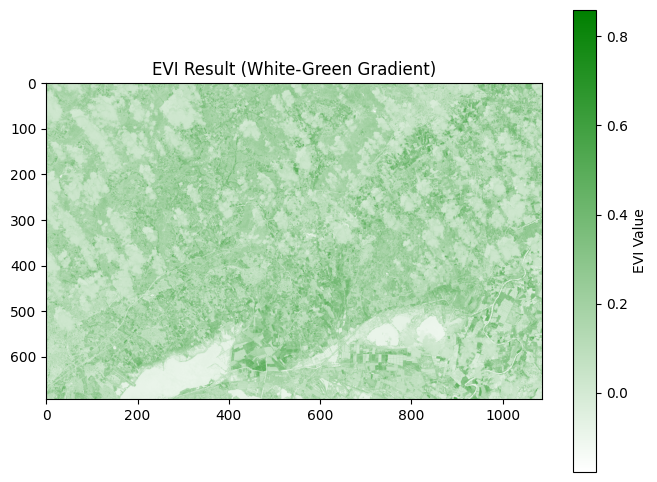

In [48]:
import rasterio
import matplotlib.pyplot as plt
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap

with BytesIO(result) as memfile:
    with rasterio.open(memfile) as src:
        arr = src.read(1)

# Create a custom white-to-green colormap
white_green = LinearSegmentedColormap.from_list('white_green', ['white', 'green'])

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap=white_green)
plt.title("EVI Result (White-Green Gradient)")
plt.colorbar(label="EVI Value")
plt.show()

**Or you can also create a process and execute it later via the "jobs" endpoint**

In [69]:
connection.create_job(process_graph)
# /!\ WARNING /!\
# For the moment the job creation return an error but the job is created on the server side

OpenEoClientException: Job creation response did not contain a valid job id

In [70]:
connection.list_jobs()

[{'id': '91a977b7-ea62-42fd-a6f5-852b1e28789b',
  'status': 'created',
  'created': '2025-10-27T15:41:28',
  'process': {'id': 'test-execution-6421a59d-8a41-4fd8-a5db-6724fcde3bb7',
   'summary': 'Enhanced Vegetation Index',
   'description': 'Computes the Enhanced Vegetation Index (EVI). It is computed with the following formula: `2.5 * (NIR - RED) / (1 + NIR + 6*RED + -7.5*BLUE)`.',
   'categories': [],
   'parameters': [],
   'returns': {'description': 'Computed EVI.', 'schema': {'type': ['OBJECT']}},
   'deprecated': False,
   'experimental': False,
   'exceptions': {},
   'examples': [],
   'links': [],
   'process_graph': {'load1': {'process_id': 'load_collection',
     'title': None,
     'description': None,
     'arguments': {'spatial_extent': {'value': {'west': 3.87,
        'south': 43.56,
        'east': 4.5,
        'north': 43.85,
        'base': 0.0,
        'height': 0.0,
        'crs': 'urn:ogc:def:crs:OGC:1.3:CRS84'},
       'type': 'VALUE'},
      'id': {'value': 'sentinel_evi_bands', 'type': 'VALUE'},
      'bands': {'value': [{'value': 0, 'type': 'VALUE'},
        {'value': 2, 'type': 'VALUE'},
        {'value': 4, 'type': 'VALUE'}],
       'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    'geotoolkit3': {'process_id': 'geotoolkit.coverage:bandselect',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'load1', 'type': 'FROM_NODE'},
      'bands': {'value': [{'value': 2, 'type': 'VALUE'}], 'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    'geotoolkit2': {'process_id': 'geotoolkit.coverage:bandselect',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'load1', 'type': 'FROM_NODE'},
      'bands': {'value': [{'value': 1, 'type': 'VALUE'}], 'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    'geotoolkit1': {'process_id': 'geotoolkit.coverage:bandselect',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'load1', 'type': 'FROM_NODE'},
      'bands': {'value': [{'value': 0, 'type': 'VALUE'}], 'type': 'ARRAY'}},
     'returns': None,
     'result': False},
    '3': {'process_id': 'geotoolkit.coverage:math:multiplyWithValue',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'geotoolkit2', 'type': 'FROM_NODE'},
      'value': {'value': 7.5, 'type': 'VALUE'}},
     'returns': None,
     'result': False},
    '1': {'process_id': 'geotoolkit.coverage:math:substract',
     'title': None,
     'description': None,
     'arguments': {'first': {'value': 'geotoolkit3', 'type': 'FROM_NODE'},
      'second': {'value': 'geotoolkit1', 'type': 'FROM_NODE'}},
     'returns': None,
     'result': False},
    '2': {'process_id': 'geotoolkit.coverage:math:multiplyWithValue',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'geotoolkit1', 'type': 'FROM_NODE'},
      'value': {'value': 6.0, 'type': 'VALUE'}},
     'returns': None,
     'result': False},
    'geotoolkit4': {'process_id': 'geotoolkit.coverage:math:sum',
     'title': None,
     'description': None,
     'arguments': {'first': {'value': 'geotoolkit3', 'type': 'FROM_NODE'},
      'second': {'value': '2', 'type': 'FROM_NODE'}},
     'returns': None,
     'result': False},
    'geotoolkit5': {'process_id': 'geotoolkit.coverage:math:sum',
     'title': None,
     'description': None,
     'arguments': {'first': {'value': 'geotoolkit4', 'type': 'FROM_NODE'},
      'second': {'value': '3', 'type': 'FROM_NODE'}},
     'returns': None,
     'result': False},
    'geotoolkit7': {'process_id': 'geotoolkit.coverage:math:sumWithValue',
     'title': None,
     'description': None,
     'arguments': {'coverage': {'value': 'geotoolkit5', 'type': 'FROM_NODE'},
      'value': {'value': 1.0, 'type': 'VALUE'}},
     'returns': None,
     'result': False},
    'geotoolkit8': {'process_id': 'geotoolkit.coverage:math:divide',
     'title': None,
     'desc

In [72]:
job = connection.job("91a977b7-ea62-42fd-a6f5-852b1e28789b")

In [73]:
job.start_and_wait()

0:00:00 Job '91a977b7-ea62-42fd-a6f5-852b1e28789b': send 'start'
0:00:00 Job '91a977b7-ea62-42fd-a6f5-852b1e28789b': created (progress 0.0%)
0:00:05 Job '91a977b7-ea62-42fd-a6f5-852b1e28789b': finished (progress 100.0%)


<BatchJob job_id='91a977b7-ea62-42fd-a6f5-852b1e28789b'>

In [74]:
job.get_results()

<JobResults for job '91a977b7-ea62-42fd-a6f5-852b1e28789b'>

In [79]:
result_file = job.get_results().download_file()

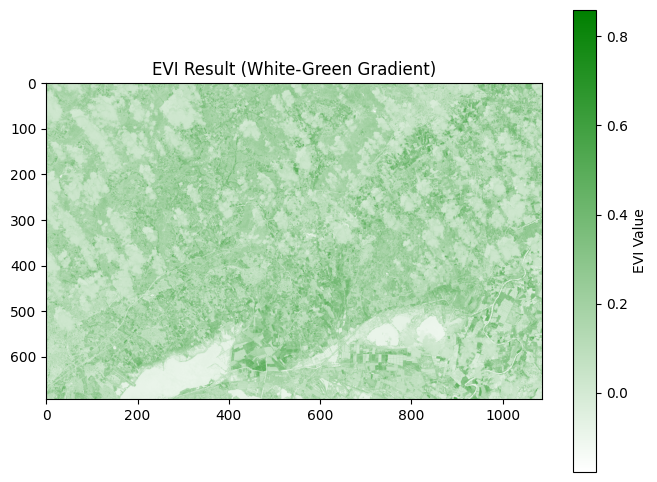

In [82]:
with rasterio.open(result_file) as src:
    arr = src.read(1)
# Create a custom white-to-green colormap
white_green = LinearSegmentedColormap.from_list('white_green', ['white', 'green'])

plt.figure(figsize=(8, 6))
plt.imshow(arr, cmap=white_green)
plt.title("EVI Result (White-Green Gradient)")
plt.colorbar(label="EVI Value")
plt.show()